In [22]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from catboost import Pool, cv
random_state = 7
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
import os
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [23]:
def find_intersection(tr, ts, iterations, learning_rate,depth, weigths, no_genes=100):
       # get current directory
    path = os.getcwd()
    parent = os.path.dirname(path)

    train = pd.read_csv(parent + '\Data\\' + tr + ".csv")
    test = pd.read_csv(parent + '\Data\\' + ts + ".csv")
    
    X_train = train.drop("target", axis=1)
    y_train = train["target"]
    
    X_test  = test.drop("target", axis=1)
    y_test = test["target"]
    
        # initialize Pool
    train_pool = Pool(X_train, 
                      y_train)
        # initialize Pool
    test_pool = Pool(X_test, 
                      y_test)
    
    start_time = time.time()

    model = CatBoostClassifier(iterations=iterations,
                           depth=depth,
                           learning_rate=learning_rate,
                           loss_function='Logloss',
                           random_state=random_state,
                           class_weights= weigths,
                           verbose=False)

    model.fit(train_pool)
    print("--- %s seconds ---" % (time.time() - start_time))
    
    LossFunctionChange = CatBoostClassifier.get_feature_importance(model, type="LossFunctionChange",data=test_pool)
    ind_LossFunctionChange = np.argpartition(LossFunctionChange, -no_genes)[-no_genes:]
    df_loss_function = pd.DataFrame()
    df_loss_function["feature"] = list(X_train.columns)
    df_loss_function["importance"] = LossFunctionChange
    df_loss_function= df_loss_function.sort_values(by = "importance", ascending = False)
    
    PredictionValuesChange = CatBoostClassifier.get_feature_importance(model)
    ind_PredictionValuesChange = np.argpartition(PredictionValuesChange, -no_genes)[-no_genes:]
    
    df_pred_value = pd.DataFrame()
    df_pred_value["feature"] = list(X_train.columns)
    df_pred_value["importance"] = PredictionValuesChange
    df_pred_value = df_pred_value.sort_values(by = "importance", ascending = False)
    
    intersection = (X_train.columns[(np.intersect1d(ind_PredictionValuesChange, ind_LossFunctionChange))])
     
    return df_loss_function, df_pred_value, intersection, LossFunctionChange,PredictionValuesChange,X_train.columns
    

In [79]:
# tr = "trainset_AMLvsALL_90_target_in"
# ts = "testset_AMLvsALL_10_target_in"

# tr = "trainset_ALLvsHealthy_80_target_in"
# ts = "testset_ALLvsHealthy_20_target_in" 

# tr = "/datasets/TrainSet-82-12709_4041_TargetIn"
# ts = "/datasets/TestSet-18-12709_4041_TargetIn"

tr = "trainset_AMLvsHealthy_80_target_in"
ts = "testset_AMLvsHealthy_20_target_in" 


no_genes = 100

# a,b,c = find_intersection(tr, ts, 200, 0.4, 4, [1,1],  no_genes )  # aml vs all
# a,b,c,d,e,f  = find_intersection(tr, ts, 300, 0.2, 3, [1,1],  no_genes )  # aml vs all

# a,b,c,d,e,f = find_intersection(tr, ts, 200, 0.1, 4, [1, 0.26], no_genes )  # all vs healthy


# a,b,c,d,e,f = find_intersection(tr,ts, 200, 0.1, 4, [0.82, 0.18],  no_genes) #aml vs healthy #Thanos
a,b,c,d,e,f = find_intersection(tr,ts, 200, 0.2, 4, [1, 0.22],  no_genes) #aml vs healthy #Romar


--- 45.5459566116333 seconds ---


In [80]:
print(c)
print(len(c))

Index(['CCL5', 'HLA-E', 'RCN1', 'TGFBI', 'MYBL2', 'CD14', 'NUP214',
       'COMMD3-BMI1', 'EPS8', 'TRAFD1', 'IGF1R', 'PRAME', 'P2RX4',
       'APOC4-APOC2', 'TFF3', 'FPR1', 'HOXB6', 'FAM50B', 'WT1', 'GP1BB',
       'FLT3', 'EDIL3', 'GPR171', 'MAML3', 'CDKN2A', 'ASAH1', 'TBC1D9B',
       'ALDH1A1', 'LCN2', 'COL4A5', 'CDC42BPA', 'GPR65', 'CHRM3', 'HOXA1',
       'HBBP1', 'TRBV21-1', 'GOLM1', 'BZW2', 'DSG2', 'AKTIP', 'DNAAF5',
       'LPAR6', 'SMYD3', 'DEPTOR', 'TIMM22', 'C3orf14', 'CXorf57', 'SLC27A5',
       'PCDH9', 'NUDT11', 'VPREB3', 'PDZRN4', 'VPREB1', 'GDF15', 'CLIC4P1',
       'SH3BP4', 'TCL1A'],
      dtype='object')
57


In [81]:
print(c)
print(len(c))

Index(['CCL5', 'HLA-E', 'RCN1', 'TGFBI', 'MYBL2', 'CD14', 'NUP214',
       'COMMD3-BMI1', 'EPS8', 'TRAFD1', 'IGF1R', 'PRAME', 'P2RX4',
       'APOC4-APOC2', 'TFF3', 'FPR1', 'HOXB6', 'FAM50B', 'WT1', 'GP1BB',
       'FLT3', 'EDIL3', 'GPR171', 'MAML3', 'CDKN2A', 'ASAH1', 'TBC1D9B',
       'ALDH1A1', 'LCN2', 'COL4A5', 'CDC42BPA', 'GPR65', 'CHRM3', 'HOXA1',
       'HBBP1', 'TRBV21-1', 'GOLM1', 'BZW2', 'DSG2', 'AKTIP', 'DNAAF5',
       'LPAR6', 'SMYD3', 'DEPTOR', 'TIMM22', 'C3orf14', 'CXorf57', 'SLC27A5',
       'PCDH9', 'NUDT11', 'VPREB3', 'PDZRN4', 'VPREB1', 'GDF15', 'CLIC4P1',
       'SH3BP4', 'TCL1A'],
      dtype='object')
57


In [96]:
def find_intersection_genes(a,b,no_genes,f):
    ind_PredictionValuesChange = np.argpartition(a, -no_genes)[-no_genes:]
    ind_LossFunctionChange = np.argpartition(b, -no_genes)[-no_genes:]
    intersection = (f[(np.intersect1d(ind_PredictionValuesChange, ind_LossFunctionChange))])
    return intersection
keep = find_intersection_genes(d,e,200,f)
print(keep)
len(keep)

Index(['CCL5', 'HLA-E', 'CTTN', 'RCN1', 'TGFBI', 'MYBL2', 'CD14', 'ATXN2L',
       'PLK2', 'NUP214',
       ...
       'C6orf48', 'SPX', 'VPREB1', 'CDCA8', 'GDF15', 'KDM7A', 'LUZP1',
       'CLIC4P1', 'SH3BP4', 'TCL1A'],
      dtype='object', length=128)


128

In [97]:
import pickle
with open("genes_to_keep.pickle", "wb") as file:
    pickle.dump(keep,file)

In [7]:
a

,feature,importance
7613,CD3D,0.001119
12389,PAX5,0.000755
2207,NRGN,0.000593
2303,TMEM243,0.000568
5142,HPR,0.000555
...,...,...
7544,RPN2,-0.000535
1884,CSF3R,-0.000581
8402,BTN2A1,-0.000584
112,CTSA,-0.000590


In [8]:
b

,feature,importance
8128,ZNF423,6.707757
12145,LEF1,6.192613
5603,PLAGL1,5.771533
11333,ATP8B4,5.214474
10135,GALNT11,3.314477
...,...,...
4345,SAA2-SAA4,0.000000
4346,SLC17A2,0.000000
4348,CHM,0.000000
4349,AKR1D1,0.000000


In [77]:
def show_imp(di,di0,k):
    %matplotlib inline 
    import matplotlib.pyplot as plt
    import shap
    import seaborn as sns
    import os
    path = os.getcwd()
    parent = os.path.dirname(path)
    dfi = di.head(k)
    # feats importance
    sns.set(rc = {'figure.figsize':(15,8)})
    # ax = dfi.plot('feature', 'importance', kind='bar', color='c')
    # ax.set_title("Feature Importance of CatBoost", fontsize = 14)
    sns.set_palette("deep")
    ax = sns.barplot(x=dfi["feature"], y=dfi["importance"], color='b')
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
    plt.savefig(parent + '/Figures/LossFunctionALMLvsHealthy.eps', dpi=300)
    print(". - .")
    print(" ")
    # feats importance LossFunctionChange
    dfi0 = di0.head(k)
    # plt.rcParams["figure.figsize"] = (15,8)
    # ax1 = dfi0.plot('feature', 'importance', kind='bar', color='m')
    # ax1.set_title("Feature Importance of LossFunctionChange", foclass_weights= 14)
    ax1 = sns.barplot(x=dfi0["feature"], y=dfi0["importance"], color="#DD8452")
    ax1.set_xticklabels(ax1.get_xticklabels(),rotation = 90)
    plt.savefig(parent + '/Figures/PredictionChangeAMLvHealthy.eps',dpi=300)

. - .
 


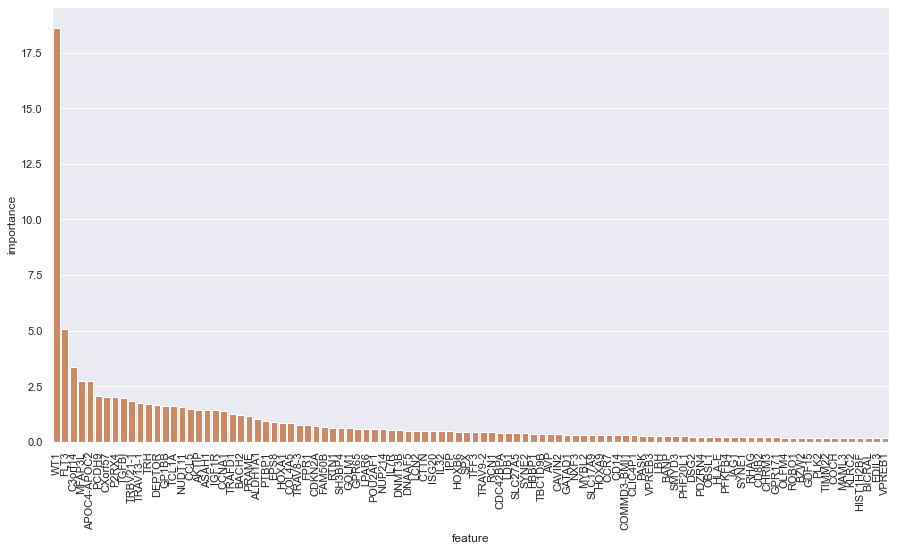

In [78]:
show_imp(a,b,100)

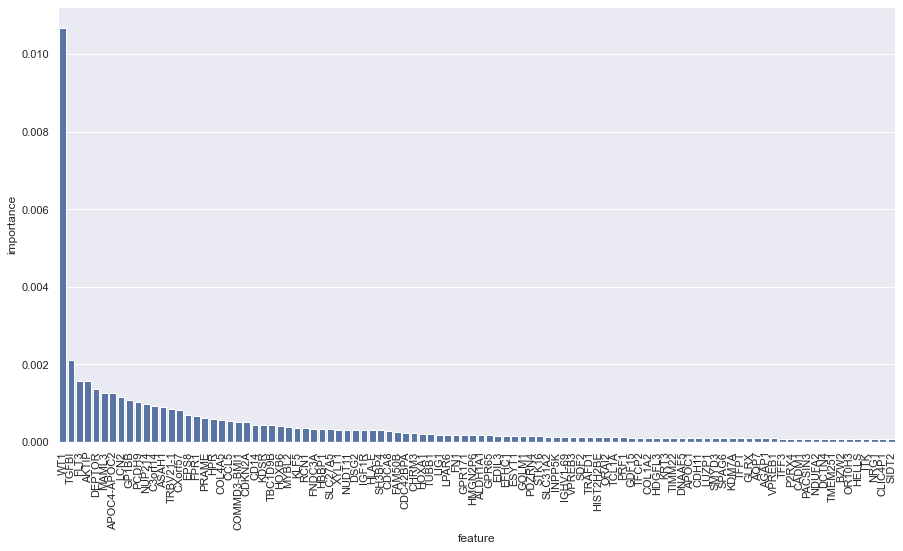

In [70]:
import matplotlib.pyplot as plt
import shap
import seaborn as sns
import os
import matplotlib.pyplot as plt
k = no_genes
path = os.getcwd()
parent = os.path.dirname(path)
dfi = a.head(k)
# feats importance
sns.set(rc = {'figure.figsize':(15,8)})
# ax = dfi.plot('feature', 'importance', kind='bar', color='c')
# ax.set_title("Feature Importance of CatBoost", fontsize = 14)
sns.set_palette("deep")
ax = sns.barplot(x=dfi["feature"], y=dfi["importance"], color='b')
ax = ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
# plt.savefig(parent + '/Figures/LossChangeAMLvsALL.eps',       dpi=300)

In [74]:
test = np.intersect1d(c, ['IGF1R', 'BACH2', 'FLT3', 'NDUFB7', 'EPS8', 'PCDH9', 'APOC4-APOC2', 'CXCL5', 'TBC1D9B', 'KDM7A', 'TCL1A', 'TPD52', 'ALDH1A1', 'GP1BB', 'LCN2', 'AOAH', 'CXorf57', 'AKTIP', 'CES1P1', 'CHRM3', 'DAB1', 'NUP214', 'CTDSPL', 'PF4', 'MAPK12', 'ASAH1', 'HHEX', 'S1PR4', 'ISG20', 'AVP', 'VPREB3', 'CDC14B', 'TRBV21-1', 'HBBP1', 'CRISP3', 'PRAME', 'PECR', 'RLN2', 'SERPINA1', 'TRAV21', 'CCNA1', 'NUDT11', 'CCL5', 'NXF3', 'GPKOW', 'ENTPD1', 'TIAM1', 'MYBL2', 'WT1', 'SYNE1', 'C3orf14', 'IFI27', 'TUBB1', 'HOXB6', 'ANAPC15', 'EGLN2', 'SPX'])

In [75]:
test

array(['AKTIP', 'ALDH1A1', 'APOC4-APOC2', 'ASAH1', 'C3orf14', 'CCL5',
       'CHRM3', 'CXorf57', 'EPS8', 'FLT3', 'GP1BB', 'HBBP1', 'HOXB6',
       'IGF1R', 'LCN2', 'MYBL2', 'NUDT11', 'NUP214', 'PCDH9', 'PRAME',
       'TBC1D9B', 'TCL1A', 'TRBV21-1', 'VPREB3', 'WT1'], dtype=object)

In [76]:
len(test)

25